In [1]:
import pandas as pd
import numpy as np
import os
import re
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from Tusc5IntegralUtils import *
from Tusc5ImageUtils import *

[2024-09-01 18:49:03,932][INFO]: Connecting Raphael@vfsmdatajoint01.fsm.northwestern.edu:3306
[2024-09-01 18:49:04,443][INFO]: Connected Raphael@vfsmdatajoint01.fsm.northwestern.edu:3306
c:\Users\Luis\anaconda3\envs\cellpose\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Importing Data

In [3]:
'''
Accepts data from the new image analysis
'''

raw_data_csv_name = # INPUT

Cell_Results = pd.read_csv('raw_data_folder/' + raw_data_csv_name + '.csv')
Cell_Results['X_vals'] = Cell_Results['X_vals'].apply(ast.literal_eval) # Makes it so cells containing lists are identifiable as lists by pandas
Cell_Results['Y_vals'] = Cell_Results['Y_vals'].apply(ast.literal_eval)
Cell_Results.head()

,Y_vals,mask_id,Stain,X_vals,file_name,DJID,Eye,eGFP_Value,eGFP_Raw_Intensity,in_rip
0,"(0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 4, 10, 53, 144,...",0,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.447577,False
1,"(1483, 1672, 1601, 1938, 1758, 1948, 2052, 247...",0,eGFP,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.447577,False
2,"(701, 802, 942, 1119, 1317, 1491, 1858, 2566, ...",0,WGA,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.447577,False
3,"(0, 0, 0, 0, 0, 0, 1, 0, 0, 6, 22, 62, 215, 48...",0,GluT1,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.447577,False
4,"(0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 7, 15, 75, 265,...",5,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.092194,False


## DJID_GEN_Eye Merge

In [4]:
'''
'DJID_GEN_EYES.csv' contains DJIDs which connect DJIDs to genotype and which eye was in the experimental or control group

This code chunk merges that dataframe with Cell_Results


Takes into consideration if file_name has variations on eye types (e.g. RA, LD)
'''

Recorded_Info = pd.read_csv('DJID_GEN_EYES_DURATION.csv')
merged_df = pd.merge(Cell_Results, Recorded_Info[['DJID', 'Genotype', 'Experimental Eye', 'Control Eye', 'Time_Condition']], on='DJID', how='left')
merged_df.loc[merged_df['Eye'].str[0] == merged_df['Experimental Eye'].str[0], 'Group_Type'] = 'Experimental'
merged_df.loc[merged_df['Eye'].str[0] == merged_df['Control Eye'].str[0], 'Group_Type'] = 'Control'
Cell_Results = merged_df.drop(columns=['Experimental Eye', 'Control Eye'])

Cell_Results.loc[Cell_Results['Genotype'] == 'wildtype', 'eGFP_Value'] = False # Making sure wildtype retinas do not have false positive eGFP cells

Cell_Results.head()

,Y_vals,mask_id,Stain,X_vals,file_name,DJID,Eye,eGFP_Value,eGFP_Raw_Intensity,in_rip,Genotype,Time_Condition,Group_Type
0,"(0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 4, 10, 53, 144,...",0,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.447577,False,het,90,Experimental
1,"(1483, 1672, 1601, 1938, 1758, 1948, 2052, 247...",0,eGFP,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.447577,False,het,90,Experimental
2,"(701, 802, 942, 1119, 1317, 1491, 1858, 2566, ...",0,WGA,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.447577,False,het,90,Experimental
3,"(0, 0, 0, 0, 0, 0, 1, 0, 0, 6, 22, 62, 215, 48...",0,GluT1,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.447577,False,het,90,Experimental
4,"(0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 7, 15, 75, 265,...",5,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.092194,False,het,90,Experimental


In [5]:
print('STATS BEFORE FILTER')

print('#'*50)
print('DJID:', Cell_Results.DJID.unique())
print('in_rip:', Cell_Results.in_rip.unique())
print('Group_type:', Cell_Results.Group_Type.unique())
print('Time Conditions:', Cell_Results.Time_Condition.unique())
print('Genotype:', Cell_Results.Genotype.unique())
print('#'*50)

print(Cell_Results.groupby('DJID')['Time_Condition'].count()/4)
print('#'*50)

STATS BEFORE FILTER
##################################################
DJID: [3603 3607 3608 3655 3657]
in_rip: [False]
Group_type: ['Experimental' 'Control']
Time Conditions: [90 60 30 15]
Genotype: ['het']
##################################################
DJID
3603    222.0
3607     11.0
3608    134.0
3655    120.0
3657     51.0
Name: Time_Condition, dtype: float64
##################################################


## Birth Data Merge


In [6]:
'''
Fetching a table to connect DJID to mouse age
Then merging that table to Cell_Results

'''

# DJ query and fetch
init_query = sln_animal.Animal.proj('dob', 'sex') * sln_animal.AnimalEvent * sln_animal.Deceased
birth_data = init_query.proj('dob', 'sex', 'date').fetch(format = 'frame')

# Reseting index and renaming columns
birth_data = birth_data.reset_index().drop(columns = ['event_id'])
birth_data = birth_data.rename(columns = {'animal_id': 'DJID', 'dob': 'birth', 'date': 'death'})

# Changing variables to date time vars
birth_data['birth'] = pd.to_datetime(birth_data['birth'])
birth_data['death'] = pd.to_datetime(birth_data['death'])

# Calculate the difference in days
birth_data['Age_Days'] = (birth_data['death'] - birth_data['birth']).dt.days

# Convert days to months (approximately, assuming ~30.44 days in a month)
birth_data['Age_Months'] = round(birth_data['Age_Days'] / 30.44,1)

# Merge
Cell_Results = Cell_Results.merge(birth_data, how = 'left', on = 'DJID')
Cell_Results = Cell_Results.drop(columns = ['birth', 'death', 'Age_Days'])
Cell_Results.head()

,Y_vals,mask_id,Stain,X_vals,file_name,DJID,Eye,eGFP_Value,eGFP_Raw_Intensity,in_rip,Genotype,Time_Condition,Group_Type,sex,Age_Months
0,"(0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 4, 10, 53, 144,...",0,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.447577,False,het,90,Experimental,Male,3.0
1,"(1483, 1672, 1601, 1938, 1758, 1948, 2052, 247...",0,eGFP,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.447577,False,het,90,Experimental,Male,3.0
2,"(701, 802, 942, 1119, 1317, 1491, 1858, 2566, ...",0,WGA,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.447577,False,het,90,Experimental,Male,3.0
3,"(0, 0, 0, 0, 0, 0, 1, 0, 0, 6, 22, 62, 215, 48...",0,GluT1,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.447577,False,het,90,Experimental,Male,3.0
4,"(0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 7, 15, 75, 265,...",5,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.092194,False,het,90,Experimental,Male,3.0


## Slice Separation and ID generation

In [7]:
'''
1) Adds a column to the dataframe which contains the z-stack slice seperation value

2) Adds a cell id

'''
Cell_Results['Slice_Seperation'] = Cell_Results['X_vals'].apply(lambda x: x[1]-x[0])

Cell_Results['Cell'] = Cell_Results.groupby(['file_name', 'mask_id']).ngroup()

In [8]:
Cell_Results.head()

,Y_vals,mask_id,Stain,X_vals,file_name,DJID,Eye,eGFP_Value,eGFP_Raw_Intensity,in_rip,Genotype,Time_Condition,Group_Type,sex,Age_Months,Slice_Seperation,Cell
0,"(0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 4, 10, 53, 144,...",0,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.447577,False,het,90,Experimental,Male,3.0,0.15,0
1,"(1483, 1672, 1601, 1938, 1758, 1948, 2052, 247...",0,eGFP,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.447577,False,het,90,Experimental,Male,3.0,0.15,0
2,"(701, 802, 942, 1119, 1317, 1491, 1858, 2566, ...",0,WGA,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.447577,False,het,90,Experimental,Male,3.0,0.15,0
3,"(0, 0, 0, 0, 0, 0, 1, 0, 0, 6, 22, 62, 215, 48...",0,GluT1,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.447577,False,het,90,Experimental,Male,3.0,0.15,0
4,"(0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 7, 15, 75, 265,...",5,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.092194,False,het,90,Experimental,Male,3.0,0.15,1


Stain: DAPI, Detected peaks at indices: [25 61]
Stain: eGFP, Detected peaks at indices: [20 39 59]
Stain: WGA, Detected peaks at indices: [13 38 54]
Stain: GluT1, Detected peaks at indices: [16 35 50]


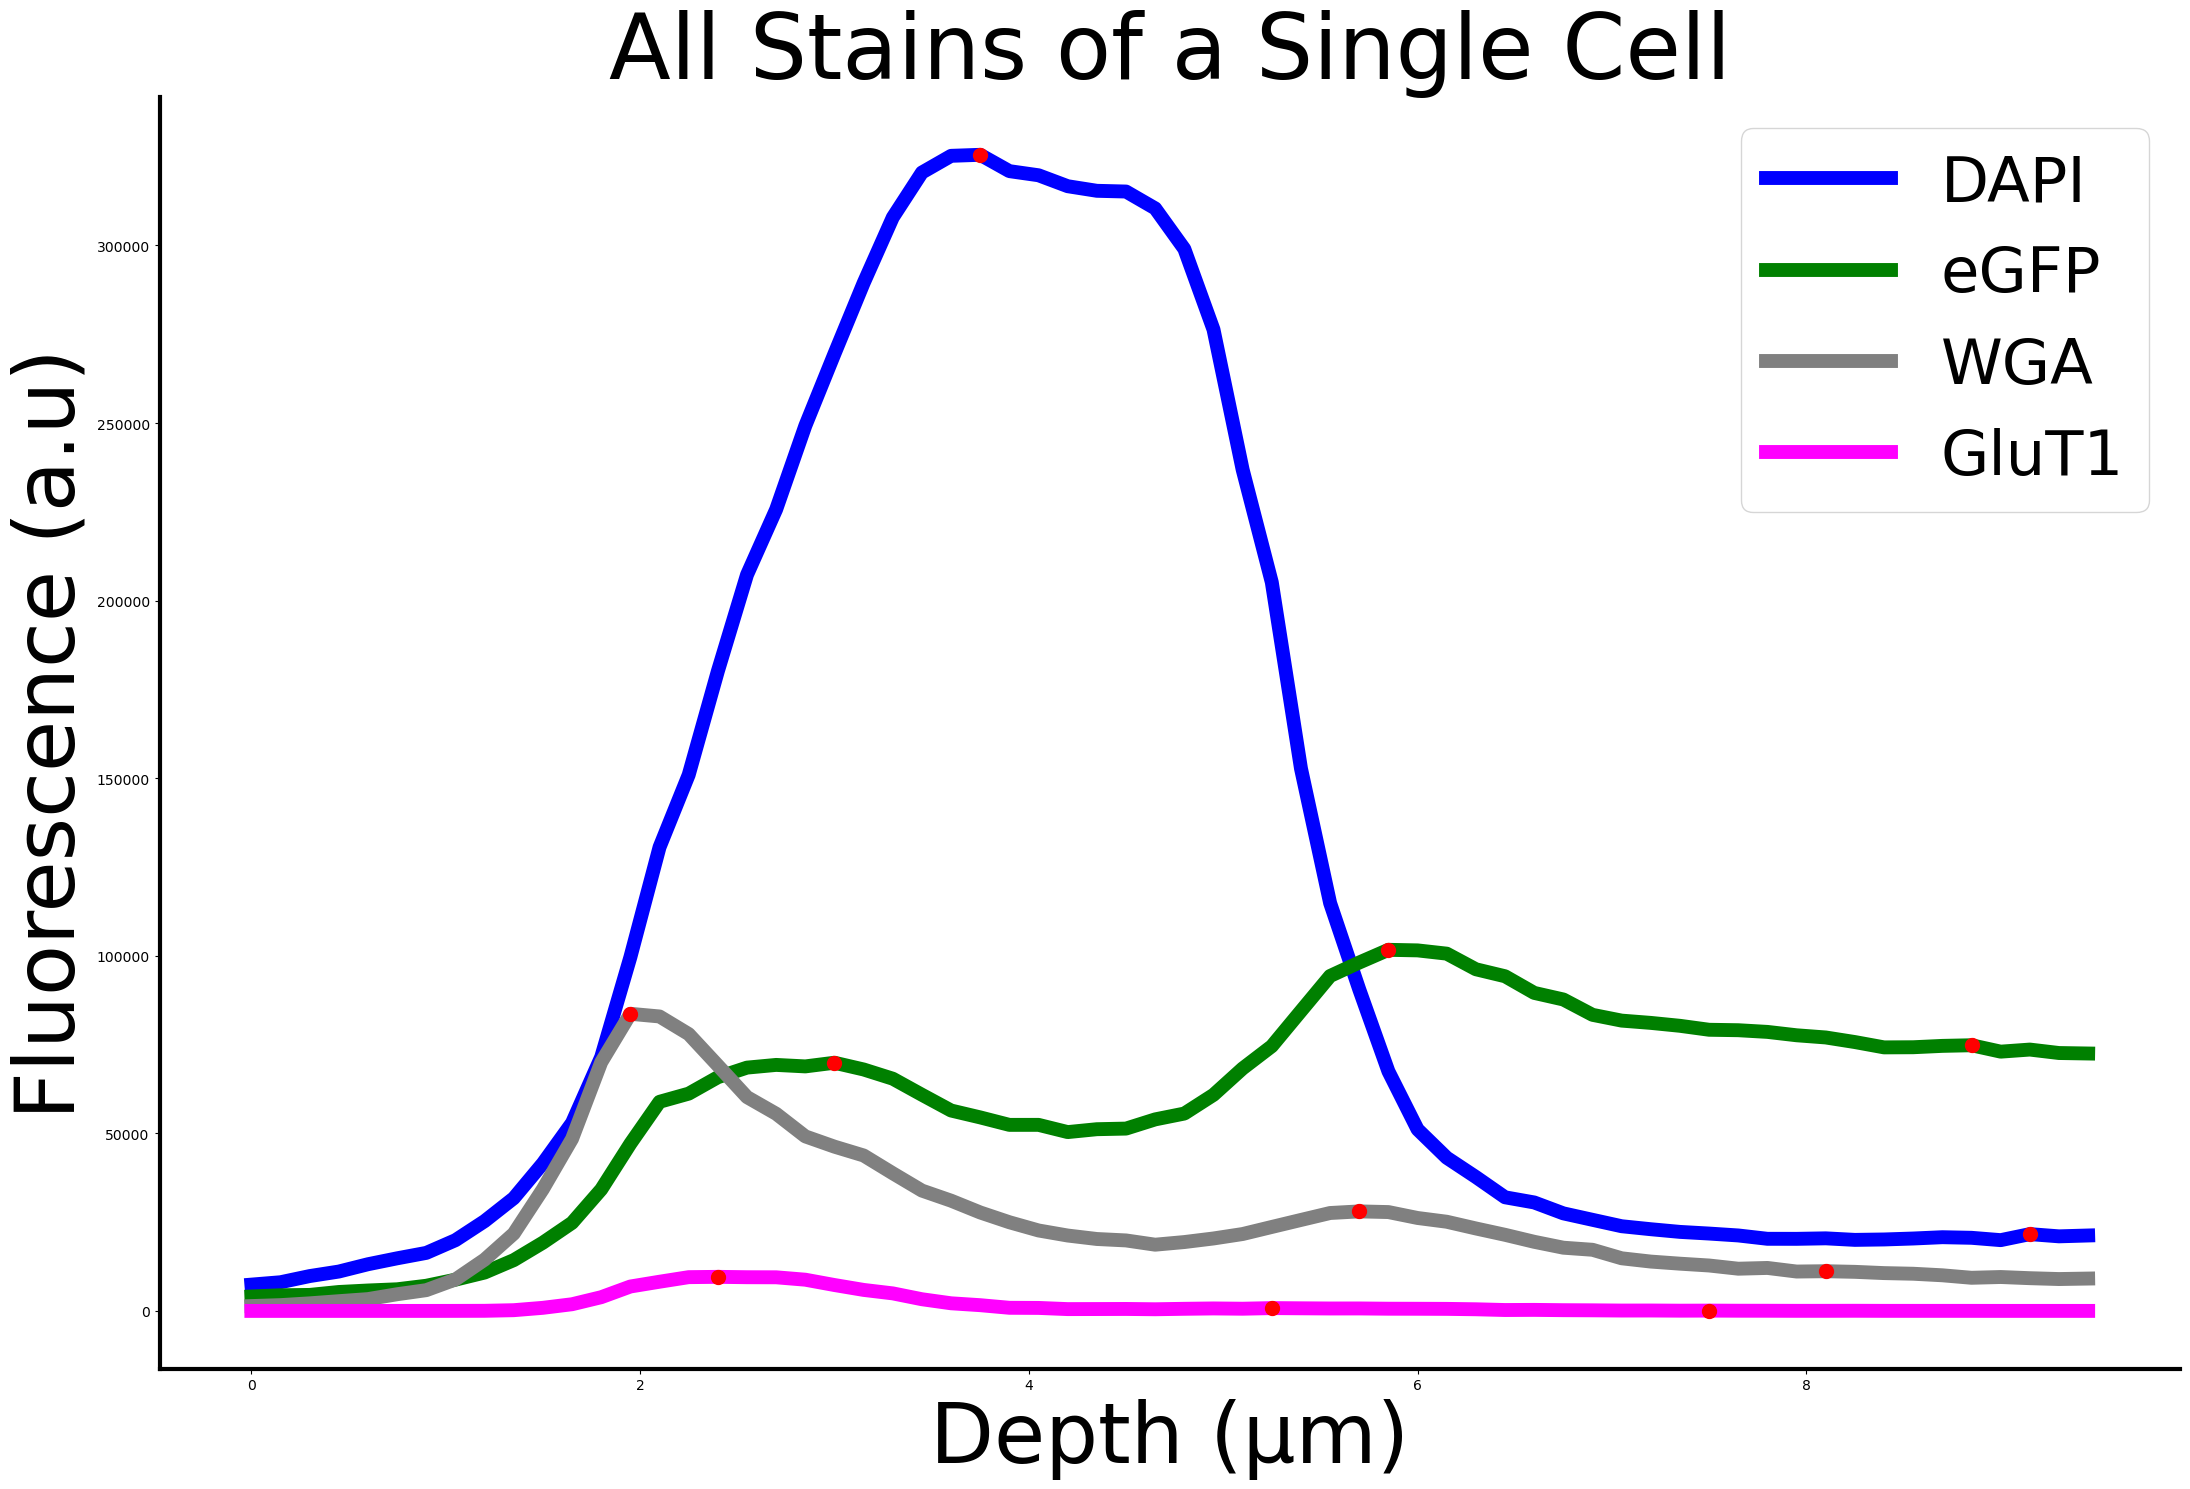

In [9]:
plot_single_cell(Cell_Results.query('Cell == 270'), prominence= 20, distance = 15)

## Filters

In [10]:
'''
Goes through each cell in Cell_Results and calculates peaks

Prominence = 25 was chosen as it experimentally retained the most number of good cells.

'''

# Peak Filter

print(f'Original number of Cells: {len(Cell_Results)/4}')

remove_list = []

for cell_number in Cell_Results['Cell'].unique():
    
    CR_Query = Cell_Results.query('Cell == @cell_number').copy()

    slice_seperation = CR_Query.iloc[0]['Slice_Seperation']

    WGA_min_distance = int(2.25 / slice_seperation) # peaks must be 2.25 microns away from eachother
    DAPI_min_distance = int(10 / slice_seperation)
    
    index_max = len(CR_Query.iloc[0]['X_vals'])

    WGA_Y_vals = CR_Query.loc[CR_Query['Stain'] == 'WGA']['Y_vals'].iloc[0]
    DAPI_Y_vals = CR_Query.loc[CR_Query['Stain'] == 'DAPI']['Y_vals'].iloc[0]

    peaks_WGA, _ = find_peaks(WGA_Y_vals, prominence= 25, distance = WGA_min_distance)
    peaks_DAPI, _ = find_peaks(DAPI_Y_vals, prominence= 25, distance = DAPI_min_distance)

    '''
    WGA Filters

    '''
    
    # 1) Remove if less than two peaks
    if len(peaks_WGA) < 2:
        remove_list.append(cell_number)
        continue
    

    if peaks_WGA[1] != peaks_WGA[-1] and WGA_Y_vals[peaks_WGA[-1]] > WGA_Y_vals[peaks_WGA[1]]:
        remove_list.append(cell_number)
        continue

    # '''
    # DAPI Filters
    # '''

    if len(peaks_DAPI) < 1:
        remove_list.append(cell_number)
        continue

    elif len(peaks_DAPI) == 1 and peaks_DAPI[0] > peaks_WGA[0] and peaks_DAPI[0] < peaks_WGA[1]:
        pass

    if peaks_DAPI[0] != peaks_DAPI[-1] and DAPI_Y_vals[peaks_DAPI[-1]] > DAPI_Y_vals[peaks_DAPI[1]]:
        remove_list.append(cell_number)

# Removing undesirable cells from main list
remove_list = np.unique(remove_list)
Cell_Results = Cell_Results[~Cell_Results['Cell'].isin(remove_list)]

print(f'Remaining Cells after Filter: {len(Cell_Results)/4}')
print(f'Cell Numbers Removed {remove_list}, count : {len(remove_list)}')

Original number of Cells: 538.0
Remaining Cells after Filter: 528.0
Cell Numbers Removed [159 170 185 219 230 288 325 367 477 486], count : 10


In [11]:
print('STATS AFTER FILTER')

print('#'*50)
print('DJID:', Cell_Results.DJID.unique())
print('in_rip:', Cell_Results.in_rip.unique())
print('Group_type:', Cell_Results.Group_Type.unique())
print('Time Conditions:', Cell_Results.Time_Condition.unique())
print('Genotype:', Cell_Results.Genotype.unique())
print('#'*50)
print(Cell_Results.groupby('DJID')['Time_Condition'].count()/4)
print('#'*50)

STATS AFTER FILTER
##################################################
DJID: [3603 3607 3608 3655 3657]
in_rip: [False]
Group_type: ['Experimental' 'Control']
Time Conditions: [90 60 30 15]
Genotype: ['het']
##################################################
DJID
3603    218.0
3607     10.0
3608    132.0
3655    117.0
3657     51.0
Name: Time_Condition, dtype: float64
##################################################


## eGFP Finder (Retired)

In [12]:
# eGFP finder
eGFP_filtered = []
remove_from_eGFP = []

for cell_number in Cell_Results['Cell'].unique():

    CR_Query = Cell_Results.query('Cell == @cell_number').copy()

    slice_seperation = CR_Query.iloc[0]['Slice_Seperation']
    DAPI_min_distance = int(10 / slice_seperation)

    DAPI_idx, _ = find_peaks(CR_Query.loc[CR_Query['Stain'] == 'DAPI']['Y_vals'].iloc[0], prominence= 25, distance = DAPI_min_distance)
    DAPI_peak_val = np.array(CR_Query.loc[CR_Query['Stain'] == 'DAPI', 'Y_vals'].iloc[0])[DAPI_idx[0]]

    # eGFP peak needs to be at least half of DAPI peak to be considered eGFP positive
    eGFP_idx, _ = find_peaks(CR_Query.loc[CR_Query['Stain'] == 'eGFP']['Y_vals'].iloc[0], prominence= 100, distance = 10, height = int(DAPI_peak_val/2))
    eGFP_peak_val = np.array(CR_Query.loc[CR_Query['Stain'] == 'eGFP', 'Y_vals'].iloc[0])[eGFP_idx]

    WGA_idx, _ = find_peaks(CR_Query.loc[CR_Query['Stain'] == 'WGA']['Y_vals'].iloc[0], prominence= 25)
    WGA_peak_val = np.array(CR_Query.loc[CR_Query['Stain'] == 'WGA', 'Y_vals'].iloc[0])[WGA_idx]

    if len(eGFP_peak_val) == 1:

        # If eGFP peak is not within WGA peaks, cell is not considered eGFP positive
        if eGFP_idx < WGA_idx[0] or eGFP_idx > WGA_idx[1]:
            remove_from_eGFP.append(cell_number)
        
        # If eGFP is not at least 1/2 the size of 
        if eGFP_peak_val > WGA_peak_val[1]/2:
            eGFP_filtered.append(cell_number)


eGFP_filtered = list(set(eGFP_filtered))
eGFP_filtered = sorted([i for i in eGFP_filtered if i not in remove_from_eGFP])

print(f'Cells with eGFP: {eGFP_filtered}, count: {len(eGFP_filtered)}')

# Labeling Cells T5 Positive or Negative
Cell_Results['T5'] = 'Negative'
Cell_Results.loc[Cell_Results['Cell'].isin(eGFP_filtered), 'T5'] = 'Positive'

Cells with eGFP: [57, 65, 75, 102, 234, 257, 296, 300, 305, 307, 314, 370, 377, 408, 412, 454, 481, 490, 524, 531], count: 20


In [13]:
# Comparison between
positive_old_identifier = np.array(eGFP_filtered)
positive_new_identifier = Cell_Results.loc[Cell_Results['eGFP_Value'] == True].Cell.unique()
print('Number of cells in old eGFP finder', len(positive_old_identifier))
print('Number of cells in new eGFP finder', len(positive_new_identifier))
print('Percent of old cells from old eGFP finder in new eGFP finder:', np.isin(positive_old_identifier, positive_new_identifier).sum()/ len(np.isin(positive_old_identifier, positive_new_identifier)) * 100, '%')



Number of cells in old eGFP finder 20
Number of cells in new eGFP finder 78
Percent of old cells from old eGFP finder in new eGFP finder: 95.0 %


In [14]:
Cell_Results

,Y_vals,mask_id,Stain,X_vals,file_name,DJID,Eye,eGFP_Value,eGFP_Raw_Intensity,in_rip,Genotype,Time_Condition,Group_Type,sex,Age_Months,Slice_Seperation,Cell,T5
0,"(0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 4, 10, 53, 144,...",0,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.447577,False,het,90,Experimental,Male,3.0,0.15,0,Negative
1,"(1483, 1672, 1601, 1938, 1758, 1948, 2052, 247...",0,eGFP,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.447577,False,het,90,Experimental,Male,3.0,0.15,0,Negative
2,"(701, 802, 942, 1119, 1317, 1491, 1858, 2566, ...",0,WGA,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.447577,False,het,90,Experimental,Male,3.0,0.15,0,Negative
3,"(0, 0, 0, 0, 0, 0, 1, 0, 0, 6, 22, 62, 215, 48...",0,GluT1,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.447577,False,het,90,Experimental,Male,3.0,0.15,0,Negative
4,"(0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 7, 15, 75, 265,...",5,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.092194,False,het,90,Experimental,Male,3.0,0.15,1,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147,"(4251, 4125, 5199, 6218, 7005, 8816, 10094, 13...",97,GluT1,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3657R_GLUT1_WGA_0003,3657,R,False,32.264890,False,het,30,Control,Female,2.1,0.15,536,Negative
2148,"(14265, 17346, 19696, 23118, 27186, 31901, 389...",101,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3657R_GLUT1_WGA_0003,3657,R,False,32.192394,False,het,30,Control,Female,2.1,0.15,537,Negative
2149,"(140688, 141146, 141931, 142453, 143514, 14560...",101,eGFP,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3657R_GLUT1_WGA_0003,3657,R,False,32.192394,False,het,30,Control,Female,2.1,0.15,537,Negative
2150,"(64841, 67148, 70016, 72788, 79980, 87432, 992...",101,WGA,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3657R_GLUT1_WGA_0003,3657,R,False,32.192394,False,het,30,Control,Female,2.1,0.15,537,Negative


## Summary of Cell_Results

In [15]:
'''
Sanity Check


'''

print('Genotype', Cell_Results['Genotype'].unique())
print('T5 Labelling', Cell_Results['Stain'].unique())
print('eGFP Types', Cell_Results['eGFP_Value'].unique())

print('\n')
print('###'*12)
print('\n')

'''
Summary of mouse information
'''

def extract_before_underscore(input_string):
    parts = input_string.split("_", 1)
    if len(parts) > 1:
        return parts[0]
    
eyes = Cell_Results['file_name'].apply(extract_before_underscore).unique()

def extract_first_four_integers(input_string):
    # Find all substrings of consecutive digits
    integers = re.findall(r'\d+', input_string)
    
    # Convert the found substrings into integers
    integers = [int(i) for i in integers]
    
    # Return the first four integers
    return integers[:4][0]

animals = list(map(extract_first_four_integers, eyes))
animals = pd.Series(animals).unique() # Extracting the unqiue values

left = 0
right = 0

for i in eyes:
    if 'R' in i:
        right += 1
    if 'L' in i:
        left +=1

positive_count = Cell_Results['eGFP_Value'].value_counts()[True]/4
total = (len(Cell_Results))/4


###
print(f'Number of mice: {len(animals)}')
print(f'Mice DJIDs: {animals}')
print(f'Number of eyes: {len(eyes)}, Left = {left} R = {right}')

###
print('\n')
print('###'*12)
print('\n')

###
print('Number of Cells', Cell_Results['Cell'].count()/4)
print('eGFP Positive', (Cell_Results.groupby('eGFP_Value').size()/4)[True])
print('eGFP Negative', (Cell_Results.groupby('eGFP_Value').size()/4)[False])
print('Positive over Total Percentage', positive_count/total*100)

Genotype ['het']
T5 Labelling ['DAPI' 'eGFP' 'WGA' 'GluT1']
eGFP Types [False  True]


####################################


Number of mice: 5
Mice DJIDs: [3603 3607 3608 3655 3657]
Number of eyes: 5, Left = 1 R = 4


####################################


Number of Cells 528.0
eGFP Positive 78.0
eGFP Negative 450.0
Positive over Total Percentage 14.772727272727273


In [16]:
Cell_Results.columns

Index(['Y_vals', 'mask_id', 'Stain', 'X_vals', 'file_name', 'DJID', 'Eye',
       'eGFP_Value', 'eGFP_Raw_Intensity', 'in_rip', 'Genotype',
       'Time_Condition', 'Group_Type', 'sex', 'Age_Months', 'Slice_Seperation',
       'Cell', 'T5'],
      dtype='object')

In [17]:
Cell_Results.groupby(['Genotype','DJID','sex'])['Age_Months'].unique()

Genotype  DJID  sex   
het       3603  Male      [3.0]
          3607  Male      [3.0]
          3608  Male      [3.0]
          3655  Female    [2.1]
          3657  Female    [2.1]
Name: Age_Months, dtype: object

# Calculations

## Defining Functions

In [18]:
'''
Function: Calculating WGA Peaks

Creates columns: WGA_Middle_Indices, Length (um)

'''

def WGA_Peaks_Finder(dataframe, prom_val:int = 25):

    # Function to find WGA peaks for each cell (via .groupby)
    def find_peaks_in_cell(cell_df):
        # Filter rows where Stain is 'WGA'
        df_WGA = cell_df.loc[cell_df['Stain'] == 'WGA']
        
        slice_seperation = df_WGA.iloc[0]['Slice_Seperation']
        WGA_min_distance = int(2.25 / slice_seperation) 
        WGA_peak_indicies = find_peaks(df_WGA['Y_vals'].iloc[0], prominence = prom_val, distance = WGA_min_distance)[0]


        return WGA_peak_indicies

    # Apply the peak finder function across cells grouped by 'Cell'
    grouped = dataframe.groupby('Cell')
    slice_separation = grouped['Slice_Seperation'].first().iloc[0]

    grouped_WGA_indices = grouped.apply(find_peaks_in_cell).reset_index().rename(columns={0: 'WGA_Middle_Indices'})    # Reset index to flatten the DataFrame and rename



    grouped_WGA_indices['Length'] = grouped_WGA_indices['WGA_Middle_Indices'].apply(lambda x: (x[1] - x[0]) * slice_separation)

    #Merge the peak indices back into the original DataFrame
    result_df = pd.merge(dataframe, grouped_WGA_indices, on='Cell', how='left')

    return result_df


In [19]:
Cell_Results

,Y_vals,mask_id,Stain,X_vals,file_name,DJID,Eye,eGFP_Value,eGFP_Raw_Intensity,in_rip,Genotype,Time_Condition,Group_Type,sex,Age_Months,Slice_Seperation,Cell,T5
0,"(0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 4, 10, 53, 144,...",0,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.447577,False,het,90,Experimental,Male,3.0,0.15,0,Negative
1,"(1483, 1672, 1601, 1938, 1758, 1948, 2052, 247...",0,eGFP,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.447577,False,het,90,Experimental,Male,3.0,0.15,0,Negative
2,"(701, 802, 942, 1119, 1317, 1491, 1858, 2566, ...",0,WGA,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.447577,False,het,90,Experimental,Male,3.0,0.15,0,Negative
3,"(0, 0, 0, 0, 0, 0, 1, 0, 0, 6, 22, 62, 215, 48...",0,GluT1,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.447577,False,het,90,Experimental,Male,3.0,0.15,0,Negative
4,"(0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 7, 15, 75, 265,...",5,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3603L_GLUT1_WGA_0001,3603,L,False,3.092194,False,het,90,Experimental,Male,3.0,0.15,1,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147,"(4251, 4125, 5199, 6218, 7005, 8816, 10094, 13...",97,GluT1,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3657R_GLUT1_WGA_0003,3657,R,False,32.264890,False,het,30,Control,Female,2.1,0.15,536,Negative
2148,"(14265, 17346, 19696, 23118, 27186, 31901, 389...",101,DAPI,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3657R_GLUT1_WGA_0003,3657,R,False,32.192394,False,het,30,Control,Female,2.1,0.15,537,Negative
2149,"(140688, 141146, 141931, 142453, 143514, 14560...",101,eGFP,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3657R_GLUT1_WGA_0003,3657,R,False,32.192394,False,het,30,Control,Female,2.1,0.15,537,Negative
2150,"(64841, 67148, 70016, 72788, 79980, 87432, 992...",101,WGA,"(0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...",3657R_GLUT1_WGA_0003,3657,R,False,32.192394,False,het,30,Control,Female,2.1,0.15,537,Negative


In [20]:
'''
Function: Calculates "Top" and "Bottom" INDICES to be used for integral boundaries

Creates columns: WGA_Top_Indices, WGA_Bottom_Indices
'''

def Top_Bottom_Indices(dataframe, microns_extension: float = 1.5):
    # Grouping / Getting Slice Separation / Calculating peaks
    grouped = dataframe.groupby('Cell')
    slice_separation = grouped['Slice_Seperation'].first()
    max_idx = Cell_Results.groupby('Cell')['X_vals'].first().apply(lambda x: len(x))
    first_peaks = grouped['WGA_Middle_Indices'].apply(lambda x: x.iloc[0] if len(x) > 0 else [np.nan, np.nan])

    # Calculate index offset for each cell based on the slice separation
    index_offset = (microns_extension / slice_separation).fillna(0).astype(int)

    # Separate the peak indices
    l_middle = first_peaks.apply(lambda x: x[0] if len(x) > 0 else np.nan)
    r_middle = first_peaks.apply(lambda x: x[1] if len(x) > 1 else np.nan)

    # Calculate modified indices
    l_top = l_middle - index_offset
    r_bot = r_middle + index_offset

    # Prepare to merge corrections for indices exceeding boundaries
    max_idx = grouped['X_vals'].apply(lambda x: len(x.iloc[0]))

    # Adjust indices to ensure they do not exceed the size of the array
    l_top = np.maximum(l_middle - index_offset, 0)
    r_bot = np.minimum(r_bot, max_idx)

    # Creating DataFrame for merging
    idx_df = pd.DataFrame({
        'Cell': grouped.size().index,  # Assures alignment with group keys
        'WGA_Top_Indices': list(zip(l_top, l_middle)),
        'WGA_Bottom_Indices': list(zip(r_middle, r_bot))
    })

    # Merge adjusted index data back into the original DataFrame
    result_df = pd.merge(dataframe, idx_df, on='Cell', how='left')

    return result_df

In [21]:
'''
Function: Calculates "Top", "Middle", "Bottom" INTEGRALS

Creates columns: Middle_Integral, Top_Integral, Bottom_Integral
'''

def TopMidBot_Integrals(dataframe):
    

    # Allows you to calculate integrals through .apply()
    def integral_calculator(arr1, arr2, integral_section:str = 'Middle'):

        if integral_section == 'Middle':

            peak_yvals = np.array(arr1)[arr2[0]:arr2[1]]

        if integral_section == 'Top':

            peak_yvals = np.array(arr1)[arr2[0]:arr2[1]] 

        if integral_section == 'Bottom': 

            peak_yvals = np.array(arr1)[arr2[0]:arr2[1]]
        return peak_yvals


    for section in ['Middle', 'Top', 'Bottom']:
        dataframe[f'{section}_Integral'] = dataframe.apply(lambda x: np.sum(integral_calculator(x['Y_vals'], x[f'WGA_{section}_Indices'], integral_section = section)), axis =1)
    
    return dataframe

In [22]:
'''
Function: Calculates "Top", "Bottom" INTEGRAL RATIOS

# Calculating the ratio of Glut1 over WGA (normalization) .5 microns about the WGA peaks

Creates columns: [WGA or GluT1]_[Top or Bot]_Surface_Integral
'''

def Surface_Integrals(dataframe):
    # Initialize a list to store results dataframes for each group
    results = []

    # Group by 'Cell' and process each group
    for (cell, group) in dataframe.groupby('Cell'):
        # Filter for WGA and GluT1 stains
        df_WGA = group.loc[group['Stain'] == 'WGA']
        df_GluT1 = group.loc[group['Stain'] == 'GluT1']


        peak_indices = df_WGA['WGA_Middle_Indices'].iloc[0]
        x_vals = df_WGA['X_vals'].iloc[0]

        # Compute slice separation and radius offset
        slice_separation = group['Slice_Seperation'].iloc[0]
        radius = 0.5
        idx_offset = int(radius / slice_separation)

        # Define borders based on peak indices and radius offset
        top_lborder = max(peak_indices[0] - idx_offset, 0)
        top_rborder = min(peak_indices[0] + idx_offset, len(x_vals))
        bottom_lborder = max(peak_indices[1] - idx_offset, 0)
        bottom_rborder = min(peak_indices[1] + idx_offset, len(x_vals))

        # Calculate integrals for 'GluT1' and 'WGA'
        top_surface_integral_GluT1 = np.sum(df_GluT1.iloc[0]['Y_vals'][top_lborder:top_rborder])
        bottom_surface_integral_GluT1 = np.sum(df_GluT1.iloc[0]['Y_vals'][bottom_lborder:bottom_rborder]) 
        top_surface_integral_WGA = np.sum(df_WGA.iloc[0]['Y_vals'][top_lborder:top_rborder])
        bottom_surface_integral_WGA = np.sum(df_WGA.iloc[0]['Y_vals'][bottom_lborder:bottom_rborder+1])

        # Ratio calculations
        Top_G_over_W = top_surface_integral_GluT1 / top_surface_integral_WGA
        Bottom_G_over_W = bottom_surface_integral_GluT1 / bottom_surface_integral_WGA

        # Append results as a DataFrame to list
        results.append(pd.DataFrame({
            'Cell': [cell],
            'GluT1_Top_Surface_Integral': [top_surface_integral_GluT1],
            'GluT1_Bot_Surface_Integral': [bottom_surface_integral_GluT1],
            'WGA_Top_Surface_Integral': [top_surface_integral_WGA],
            'WGA_Bot_Surface_Integral': [bottom_surface_integral_WGA],
            'Top_Surface_Ratio': [Top_G_over_W],
            'Bot_Surface_Ratio': [Bottom_G_over_W]
        }))

    # Concatenate all results into a single DataFrame
    results_df = pd.concat(results, ignore_index=True)

    # Merge adjusted index data back into the original DataFrame

    dataframe = dataframe.merge(results_df, on='Cell', how='left')
    
    return dataframe

In [23]:
"""
Function: Reshapes columns, so that each group has a column with '{Stain}_{Integral_Type}'. 4 x 3 = 12 columns are added
"""

def Reshape_Integrals(dataframe):

    # Make pivot table
    pivot_df = dataframe.pivot_table(
        index=['Cell'], 
        columns='Stain',
        values=['Middle_Integral', 'Top_Integral', 'Bottom_Integral'],
        aggfunc='first' 
    )

    # Flatten the multi-level column headers and format them
    pivot_df.columns = [f'{col[1]}_{col[0]}' for col in pivot_df.columns.values]

    pivot_df.reset_index(inplace=True) # Cell is a column used to merge 

    result_df = pd.merge(dataframe, pivot_df)

    return result_df

In [24]:
Cell_Results_Calcs = Cell_Results.copy()

# These functions find indices
Cell_Results_Calcs = WGA_Peaks_Finder(Cell_Results_Calcs)
Cell_Results_Calcs = Top_Bottom_Indices(Cell_Results_Calcs)

# These functions calculate integrals using the index boundaries
Cell_Results_Calcs = TopMidBot_Integrals(Cell_Results_Calcs)
Cell_Results_Calcs = Reshape_Integrals(Cell_Results_Calcs)
Cell_Results_Calcs = Surface_Integrals(Cell_Results_Calcs)

## Export

In [25]:
'''
Making new dataframe for export
- Keeps certain columns
- Renames columns
- Mapping column categories to new names (e.g. eGFP Positive -> 1)
'''

# Columns to Keep
keep_cols = ['DJID', 'Genotype', 'Eye', 'sex', 'Age_Months', 'eGFP_Value', 'Group_Type', 'in_rip', 'Length', 'Time_Condition',
             'GluT1_Top_Surface_Integral', 'GluT1_Bot_Surface_Integral', 'WGA_Top_Surface_Integral', 'WGA_Bot_Surface_Integral',
             'GluT1_Top_Integral', 'GluT1_Middle_Integral', 'GluT1_Bottom_Integral',
             'WGA_Top_Integral', 'WGA_Middle_Integral', 'WGA_Bottom_Integral']

# Columns to rename
renamed_cols = {'sex': 'Sex',
                'Length': 'Length_um',
                'in_rip': 'In_Rip',
                'Group_Type' :'Experimental_Condition'}

Export_df = Cell_Results_Calcs.groupby('Cell').first().loc[:, keep_cols].reset_index(drop = True)
Export_df = Export_df.rename(columns = renamed_cols)

# Remapping values
Export_df['eGFP_Value'] = Export_df['eGFP_Value'].astype(int)
Export_df['In_Rip'] = Export_df['In_Rip'].astype(int)

Exp_Con_map = {'Experimental': 'Light Flicker', 'Control': 'Dark'}
Export_df['Experimental_Condition'] = Export_df['Experimental_Condition'].map(Exp_Con_map)#.fillna(Export_df['Experimental_Condition'])

# Checking for NA vals
if Export_df.isna().sum().sum() > 0:
    print('There are NA values, check for problems')

Export_df

,DJID,Genotype,Eye,Sex,Age_Months,eGFP_Value,Experimental_Condition,In_Rip,Length_um,Time_Condition,GluT1_Top_Surface_Integral,GluT1_Bot_Surface_Integral,WGA_Top_Surface_Integral,WGA_Bot_Surface_Integral,GluT1_Top_Integral,GluT1_Middle_Integral,GluT1_Bottom_Integral,WGA_Top_Integral,WGA_Middle_Integral,WGA_Bottom_Integral
0,3603,het,L,Male,3.0,0,Light Flicker,0,3.75,90,3184,821,139673,63515,794,14866,490,88639,296237,80586
1,3603,het,L,Male,3.0,0,Light Flicker,0,2.70,90,8606,5120,190966,108178,2150,27421,5015,138168,331592,141310
2,3603,het,L,Male,3.0,0,Light Flicker,0,2.55,90,14177,6742,360617,269820,4002,39828,7378,241663,719761,354142
3,3603,het,L,Male,3.0,0,Light Flicker,0,2.25,90,6762,4344,293783,201291,1389,19088,4771,179458,587681,273620
4,3603,het,L,Male,3.0,0,Light Flicker,0,4.05,90,2791,1513,125655,60242,1027,24868,701,89147,289750,74709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,3657,het,R,Female,2.1,0,Dark,0,2.55,30,85314,38368,846066,646902,55067,211189,59328,869512,1986111,898316
524,3657,het,R,Female,2.1,1,Dark,0,3.60,30,148883,111588,1624741,1314405,95837,650920,140373,1621005,4883147,1828578
525,3657,het,R,Female,2.1,0,Dark,0,3.60,30,116513,97539,1324715,1069373,74961,583365,120926,1313182,4045023,1488606
526,3657,het,R,Female,2.1,0,Dark,0,2.70,30,107488,84570,1306239,1058037,76477,350124,109018,1361795,3047776,1461181


In [27]:
Export_df = Export_df.loc[Export_df['Genotype'] != 'wildtype']

processed_data_name_csv = # INPUT NAME:str
Export_df.to_csv('processed_data_folder' + processed_data_name_csv + '.csv', index = False)